In [1]:
import torch #基本モジュール
from torch.autograd import Variable #自動微分用
import torch.nn as nn #ネットワーク構築用
import torch.optim as optim #最適化関数
import torch.nn.functional as F #ネットワーク用の様々な関数
import torch.utils.data #データセット読み込み関連
import torchvision #画像関連
from torchvision import datasets, models, transforms #画像用データセット諸々

import numpy as np
import argparse
import json
from logging.config import dictConfig
from logging import getLogger
import os
import time

In [2]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # [3, 32, 32] => [6, 28, 28]
        self.conv2 = nn.Conv2d(6, 16, 5) # [6, 28, 28] => [16, 24, 24]
        self.pool = nn.MaxPool2d(2, 2) # [N,C,H,W] => [N, C, H/2, W/2]
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
def train(model, device, train_loader, optimizer, criterion, logger):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            logger.debug("[train] batch : %s/%s (%.0f%%),\tloss : %.6f",
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
    return (None, loss.item())

In [4]:
def test(model, device, test_loader, criterion, logger):
    model.eval()
    test_loss = []
    correct = 0
    result = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss.append(criterion(output, target).item())  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            result += torch.eq(torch.max(output, 1).indices, target)
            
    logger.debug("[dump] %s", test_loss)
    test_loss = np.mean(np.array(test_loss))
    accuracy = 100. * correct / len(test_loader.dataset)
    
    logger.debug("[test] ave loss : %.4f,\taccu : %d/%d(%.0f%%)",
        test_loss, correct, len(test_loader.dataset), accuracy)
    
    return (torch.tensor(result).numpy(), (test_loss, accuracy))

In [7]:
def main():
    with open('logging.json') as f:
        dictConfig(json.load(f))
    logger = getLogger('env')
    logger.debug("<" * 40)
    logger.info("[system] start")
    logger.info("[meta] データを分割して交換するアルゴリズム")
    
    start_time = time.time()

    def fetch_args(args=[]):
        parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
        parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                            help='input batch size for training (default: 64)')
        parser.add_argument('--epochs', type=int, default=14, metavar='N',
                            help='number of epochs to train (default: 14)')
        parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
                            help='learning rate (default: 0.001)')
        parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                            help='learning rate momentum (default: 0.9)')
        parser.add_argument('--dataset', default="cifar10", metavar='D')
        parser.add_argument('--model', default="cnn", metavar='M')
        parser.add_argument('--optimizer', default="sgd", metavar='O')
        parser.add_argument('--criterion', default="cross_entropy_loss", metavar='C')
        parser.add_argument('--save-model', action='store_true', default=False,
                            help='For Saving the current Model')
        return parser.parse_args(args=args)
  
    args = fetch_args(["--epochs", "1", "--batch-size", "16"])
    for arg in vars(args):
        logger.info("[param] %s=%s", arg, vars(args)[arg])
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    logger.info("[device] %s", device)
    
    #画像の変形処理
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    #CIFAR-10のtrain, testsetのロード
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    
    model_X = CNN().to(device)
    model_Y = CNN().to(device)
    optimizer_X = optim.SGD(model_X.parameters(), lr=args.lr, momentum=args.momentum)
    optimizer_Y = optim.SGD(model_Y.parameters(), lr=args.lr, momentum=args.momentum)
    criterion = nn.CrossEntropyLoss()
    
    # init
    N = int(len(trainset) / 2)
    indices = np.arange(2 * N)
    A, B = indices[:N], indices[N:]
    
    log = {"X_train":[], "X_test":[], "Y_train":[], "Y_test":[], "X_acc":[], "Y_acc":[]}

    for epoch in range(args.epochs):
        logger.debug("-" * 20)
        logger.info("[system] epoch %d", epoch)
        
        # Split
        A_loader = torch.utils.data.DataLoader(
            torch.utils.data.Subset(trainset, A), batch_size=args.batch_size)
        B_loader = torch.utils.data.DataLoader(
            torch.utils.data.Subset(trainset, B), batch_size=args.batch_size)
        
        # test B
        logger.info("[system] train_a -> test_b")
        (_, loss_XA) = train(model_X, device, A_loader, optimizer_X, criterion, logger)
        (testB, (loss_XB, acc_X)) = test(model_X, device, B_loader, criterion, logger)
        
        # test A
        logger.info("[system] train_b -> test_a")
        (_, loss_YB) = train(model_Y, device, B_loader, optimizer_Y, criterion, logger)
        (testA, (loss_YA, acc_Y)) = test(model_Y, device, A_loader, criterion, logger)
        
        # Swap
        A_o, A_x = A[testA], A[np.logical_not(testA)]
        B_o, B_x = B[testB], B[np.logical_not(testB)]
        s = min(len(A_x), len(B_o))
        A = np.concatenate([A_o, B_o[:s], A_x[s:]])
        B = np.concatenate([B_x, A_x[:s], B_o[s:]])
        
        # log
        logger.debug("[dump] test_b : %s...", testB[:10])
        logger.debug("[dump] test_a : %s...", testA[:10])
        logger.debug("[dump] swap : B -> A : %s...", B_o[:s][:10])
        logger.debug("[dump] swap : A -> B : %s...", A_x[:s][:10])
        logger.debug("[dump] X loss : %s / %s,\tacc : %s", loss_XA, loss_XB, acc_X)
        logger.debug("[dump] Y loss : %s / %s,\tacc : %s", loss_YB, loss_YA, acc_Y)
        log["X_train"].append(loss_XA)
        log["X_test"].append(loss_XB)
        log["Y_train"].append(loss_YB)
        log["Y_test"].append(loss_YA)
        log["X_acc"].append(acc_X)
        log["Y_acc"].append(acc_Y)
    
    logger.debug("%s statistics %s", "-" * 10, "-" * 10)
    logger.info("[stat] X train loss : %s", log["X_train"])
    logger.info("[stat] X test loss : %s", log["X_test"])
    logger.info("[stat] Y train loss : %s", log["Y_train"])
    logger.info("[stat] Y test loss : %s", log["Y_test"])
    logger.info("[stat] X accuracy : %s", log["X_acc"])
    logger.info("[stat] Y accuracy : %s", log["Y_acc"])
    logger.info("[stat] elapsed time : %s[s]", time.time() - start_time)
    
    if args.save_model:
        logger.info("[system] saving...")
        torch.save(model.state_dict(), "swap.pt")
    
    logger.info("[system] finish")

if __name__ == '__main__':
    main()

[system] start
[meta] データを分割して交換するアルゴリズム
[param] batch_size=16
[param] epochs=1
[param] lr=0.001
[param] momentum=0.9
[param] dataset=cifar10
[param] model=cnn
[param] optimizer=sgd
[param] criterion=cross_entropy_loss
[param] save_model=False
[device] cpu


Files already downloaded and verified


[system] epoch 0
[system] train_a -> test_b
[system] train_b -> test_a
[stat] X train loss : [1.7897357940673828]
[stat] X test loss : [2.0386693585170663]
[stat] Y train loss : [2.214972972869873]
[stat] Y test loss : [2.2158003693883876]
[stat] X accuracy : [26.544]
[stat] Y accuracy : [20.844]
[stat] elapsed time : 69.36411929130554[s]
[system] finish


In [ ]:
#画像の変形処理
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#CIFAR-10のtrain, testsetのロード
#変形はtransformを適用
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

#DataLoaderの適用->これによりバッチの割り当て・シャッフルをまとめて行うことができる
#batch_sizeでバッチサイズを指定
#num_workersでいくつのコアでデータをロードするか指定(デフォルトはメインのみ)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=2)

In [79]:
r = [torch.tensor(False), torch.tensor(True)]
torch.tensor(r).numpy()


array([False,  True])

In [85]:
import csv

log = {"A_acc":["a", "bb"], "B_acc":[1, 2]}

with open("stock.csv", "w", encoding="utf-8") as f:
    writer = csv.writer(f, lineterminator="\n")
    writer.writerows(log)

In [102]:
from logging import getLogger, StreamHandler, DEBUG
logger = getLogger(__name__)
handler = StreamHandler()
handler.setLevel(DEBUG)
logger.setLevel(DEBUG)
logger.addHandler(handler)
logger.propagate = False

print("a")

a


In [121]:
# from logging import getLogger
logger = getLogger(__name__)

from logging import StreamHandler, basicConfig, DEBUG, getLogger, Formatter

def setup_logger(log_filename):
    format_str = '%(asctime)s@%(name)s %(levelname)s # %(message)s'
    basicConfig(filename=log_filename, level=DEBUG, format=format_str)
    stream_handler = StreamHandler()
    stream_handler.setFormatter(Formatter(format_str))
    getLogger().addHandler(stream_handler)
    

logger.info("messagea")

logger.info("mess")


messagea
messagea
messagea
messagea
messagea
messagea
messagea
messagea
messagea
messagea
mess
mess
mess
mess
mess
mess
mess
mess
mess
mess


In [120]:
setup_logger("test")

In [124]:
from logging import StreamHandler, basicConfig, INFO, getLogger, Formatter, shutdown

def setup_logger(log_filename):
    format_str = '%(asctime)s@%(name)s %(levelname)s # %(message)s'
    basicConfig(filename=log_filename, level=INFO, format=format_str)
    stream_handler = StreamHandler()
    stream_handler.setFormatter(Formatter(format_str))
    getLogger().addHandler(stream_handler)

def kill_logger():
    # for l in getLogger(__name__):
    # logger = loggers.get(l)
    for h in logger.handlers:
        logger.removeHandler(h)
    # getLogger().removeHandler()
    shutdown()
    return

logger = getLogger(__name__)
setup_logger("log.txt")

logger.info("aa")
print(logger)
# kill_logger()

aa
aa
aa
aa
aa
aa
aa
aa
aa
aa


<Logger __main__ (DEBUG)>


In [144]:
import json
from logging.config import dictConfig

with open('logging.json') as f:
    dictConfig(json.load(f))


# 動作確認
from logging import getLogger

# RootLogger: error のみが標準エラーに
root_logger = getLogger()
root_logger.debug('RootLogger: debug')
root_logger.error('RootLogger: error')

# myapp: debug は指定したファイルに
# myapp: error は指定したファイルと標準エラーに
myapp_logger = getLogger('env')
myapp_logger.debug('myapp: debug')
myapp_logger.error('myapp: error')
myapp_logger = getLogger('env.model')
myapp_logger.error('env: error')

# これはすべて無視される
hoge_logger = getLogger('hoge.fuga.piyo')
hoge_logger.debug('hoge: debug')
hoge_logger.error('hoge: error')

2020-04-29 19:33:53,564: RootLogger: error
2020-04-29 19:33:53,566: myapp: error
2020-04-29 19:33:53,568: env: error


In [160]:
parser = argparse.ArgumentParser()
parser.add_argument('--foo')
args = parser.parse_args(['--foo', 'BAR'])
for a in vars(args):
    print(a, vars(args)[a])
print(vars(args))


foo BAR
{'foo': 'BAR'}


In [21]:
# exp main
m_x_train_loss = [2.288025379180908, 1.854137897491455, 1.7273635864257812, 1.45737886428833, 1.3322714567184448, 1.3078572750091553, 1.3629910945892334, 1.3265225887298584, 1.2427623271942139, 1.178240180015564, 1.094214677810669, 1.1634907722473145, 1.0996596813201904, 1.1158974170684814, 1.0118272304534912, 1.0208563804626465, 1.0107688903808594, 0.8501958847045898, 0.8958674073219299, 0.774604320526123, 0.7631874084472656, 0.7437644004821777, 0.8369741439819336, 0.798240065574646, 1.2795028686523438]
m_x_test_loss = [2.240487919506627, 2.0081781863556105, 1.9855095264778944, 2.1642124908365505, 2.3438860632560226, 2.3660928456736006, 2.4317822350345204, 2.620276643233809, 2.7199758346921272, 2.8730840539215317, 2.9618033839965276, 3.00621501852592, 3.158214510707465, 3.1677522714215827, 3.189254136819223, 3.188377470788632, 3.2310182273349772, 3.2078502377446307, 3.2170157574417493, 3.281280594000203, 3.420853141859717, 3.5144480876028728, 3.615827125230815, 3.701036387235784, 3.7283214680750403]
m_y_train_loss = [2.4142141342163086, 1.5543699264526367, 0.19778665900230408, 0.23293083906173706, 0.13564211130142212, 0.19824475049972534, 0.8459981679916382, 0.01066499948501587, 0.07485067844390869, 0.5425605177879333, 0.7458614110946655, 0.21733249723911285, 1.2879126071929932, 0.04729515314102173, 0.07440656423568726, 0.6998357772827148, 0.0025858283042907715, 0.15520411729812622, 0.01651930809020996, 0.1700097918510437, 0.00644761323928833, 0.11731904745101929, 0.2039785385131836, 0.018861770629882812, 0.9370211958885193]
m_y_test_loss = [2.0330521650064166, 1.7720401763000782, 6.50136181217352, 3.333354907583443, 8.564231173386196, 2.7435420698850335, 4.255091821296964, 3.8134682301243603, 3.5727248711896418, 2.9867952860896585, 2.8871546805057475, 3.9461203044994244, 2.6464209466772206, 4.867463631101396, 3.2882710109612, 5.5193515073886985, 3.2386772191951616, 3.6259085398050583, 4.360217468499641, 4.265082189795381, 4.6662463931103435, 4.5525197658451875, 4.234833705038194, 4.781921831703842, 4.3116312874046105]
m_x_acc = [15.468, 24.508, 20.668, 13.52, 7.556, 7.096, 6.864, 4.98, 3.176, 3.724, 2.948, 3.096, 2.468, 1.672, 2.444, 1.996, 1.92, 2.776, 1.904, 1.66, 1.004, 0.896, 0.704, 0.88, 0.992]
m_y_acc = [26.676, 31.244, 16.52, 32.64, 10.116, 31.72, 5.884, 28.516, 12.96, 25.568, 25.124, 23.568, 32.108, 23.204, 34.372, 26.544, 34.028, 33.38, 33.416, 33.964, 32.972, 34.04, 36.92, 38.436, 38.348]


In [22]:
# exp baseline
b_x_train_loss = [1.8339635133743286, 1.6075594425201416, 1.5646916627883911, 1.4751136302947998, 1.361932396888733, 1.2491068840026855, 1.138421654701233, 1.0759618282318115, 1.0412476062774658, 0.9572204351425171, 0.9483405351638794, 0.9316418766975403, 0.8921067118644714, 0.8888096809387207, 0.8420193791389465, 0.7329766750335693, 0.6785648465156555, 0.6508007645606995, 0.5793047547340393, 0.5481230616569519, 0.48123276233673096, 0.44880324602127075, 0.42180633544921875, 0.30240172147750854, 0.31743207573890686]
b_x_test_loss = [2.1110229269480447, 1.6705207288532171, 1.5288082731509927, 1.4491184713820655, 1.3900613765722654, 1.3508085648523869, 1.3145048611452392, 1.292858632573392, 1.2760242365982315, 1.2652753282264495, 1.252878129215326, 1.2460683285427339, 1.251505480942174, 1.258464446681017, 1.2671315856683125, 1.2606168866958363, 1.2823017077879195, 1.3184130398874776, 1.355862097563228, 1.38871339186597, 1.4275211941639125, 1.4860073058596042, 1.5128921037176368, 1.5769022961343167, 1.6559533543374703]
b_x_acc = [24.172, 37.656, 43.86, 47.3, 49.644, 51.416, 53.224, 54.244, 55.052, 55.84, 56.492, 56.984, 57.256, 57.324, 57.352, 57.912, 57.696, 57.424, 57.16, 56.988, 56.94, 56.74, 56.644, 56.36, 55.98]


In [23]:
# exp notrain
n_x_test_loss = [2.30429244346521, 2.314543409829558, 2.314521041346603, 2.3145063120206806, 2.314521041346603, 2.3145063120206806, 2.314521041346603, 2.3145063120206806, 2.314521041346603, 2.3145063120206806, 2.314521041346603, 2.3145063120206806, 2.314521041346603, 2.3145063120206806, 2.314521041346603, 2.3145063120206806, 2.314521041346603, 2.3145063120206806, 2.314521041346603, 2.3145063120206806, 2.314521041346603, 2.3145063120206806, 2.314521041346603, 2.3145063120206806, 2.314521041346603]
n_y_test_loss = [2.304065739277152, 2.30612972632327, 2.3061281867463546, 2.3061297278486608, 2.3061281867463546, 2.3061297278486608, 2.3061281867463546, 2.3061297278486608, 2.3061281867463546, 2.3061297278486608, 2.3061281867463546, 2.3061297278486608, 2.3061281867463546, 2.3061297278486608, 2.3061281867463546, 2.3061297278486608, 2.3061281867463546, 2.3061297278486608, 2.3061281867463546, 2.3061297278486608, 2.3061281867463546, 2.3061297278486608, 2.3061281867463546, 2.3061297278486608, 2.3061281867463546]
n_x_acc = [10.252, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148]
n_y_acc = [9.868, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872]


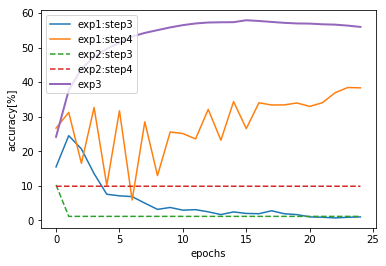

In [37]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(np.arange(25), m_x_acc, label="exp1:step3")
plt.plot(np.arange(25), m_y_acc, label="exp1:step4")
plt.plot(np.arange(25), n_x_acc, label="exp2:step3", linestyle="--")
plt.plot(np.arange(25), n_y_acc, label="exp2:step4", linestyle="--")
plt.plot(np.arange(25), b_x_acc, label="exp3", linewidth = 2)
plt.xlabel("epochs")
plt.ylabel("accuracy[%]")
# plt.title("compare accuracy")
plt.legend()
plt.show()
fig.savefig("accuracy.png")

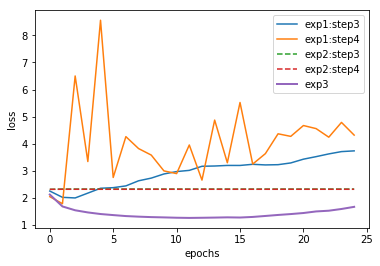

In [34]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(np.arange(25), m_x_test_loss, label="exp1:step3")
plt.plot(np.arange(25), m_y_test_loss, label="exp1:step4")
plt.plot(np.arange(25), n_x_test_loss, label="exp2:step3", linestyle="--")
plt.plot(np.arange(25), n_y_test_loss, label="exp2:step4", linestyle="--")
plt.plot(np.arange(25), b_x_test_loss, label="exp3", linewidth = 2)
plt.xlabel("epochs")
plt.ylabel("loss")
# plt.title("compare accuracy")
plt.legend()
plt.show()
fig.savefig("loss.png")